 ## Data Prep

 We'll load Shiller's file that he publishes on his website: https://shillerdata.com/

 This contains a historical time series of stock and bond market performance going back to 1871.


In [ ]:
import os
import time
import requests
import numba as nb
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from pathlib import Path
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool, cpu_count
from itertools import product
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats

In [ ]:
def parse_shiller_date(series):
    """
    Convert Shiller-style yyyy.mm strings/floats into proper datetimes.
    Examples:
      1950.01 -> 1950-01-01
      1950.1  -> 1950-10-01
      1950.11 -> 1950-11-01
    """
    s = series.astype(str).str.strip()

    def _norm(val):
        year, month_part = val.split(".", 1)
        # Special case: .1 means October (Excel dropped the zero)
        if month_part == "1":
            month = "10"
        else:
            month = month_part.zfill(2)
        return f"{year}-{month}-01"

    return pd.to_datetime(s.map(_norm), format="%Y-%m-%d")

In [ ]:
local_path = Path(os.path.join("tempdir", "shillerdata.xls"))

# This is the link found in https://shillerdata.com/
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/9becfac9-1778-47a6-b40e-299d8c616706/ie_data.xls"

# Check if file exists and is less than 30 days old
def needs_update(path, days=30):
    if not path.exists():
        return True
    age_days = (time.time() - path.stat().st_mtime) / (24 * 3600)
    return age_days > days

# Download if missing or outdated
if needs_update(local_path):
    local_path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Read multi-line headers (rows 4–7) and collapse them
headers_raw = pd.read_excel(local_path, sheet_name="Data", skiprows=4, nrows=4, header=None)
headers = (
    headers_raw.fillna("")
    .astype(str)
    .agg(" ".join)           # join rows into one string
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # clean spaces
)

# Read the actual data (starting row 8)
df = pd.read_excel(local_path, sheet_name="Data", skiprows=8)
df.columns = headers

# Drop the last row which contains footnotes
df = df.iloc[:-1].reset_index(drop=True)

# TEMPORARY: Also drop the second to last row which as of 20250913 is a duplicate
df = df.iloc[:-1].reset_index(drop=True)

df["Date"] = parse_shiller_date(df["Date"])

df.tail()

,Date,S&P Comp. P,Dividend D,Earnings E,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Earnings Ratio P/E10 or CAPE,,Earnings Ratio TR P/E10 or TR CAPE,,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1850,2025-04-01,5369.495714,76.546867,219.026667,320.795,2025.291667,4.28,5413.320220,77.171624,3.641872e+06,...,32.621270,NaN,35.015341,NaN,0.018767,0.992343,39.643654,NaN,NaN,NaN
1851,2025-05-01,5810.919524,76.948434,221.363333,321.465,2025.375000,4.42,5846.136807,77.414782,3.937395e+06,...,35.076007,NaN,37.636543,NaN,0.014912,1.006896,39.258095,NaN,NaN,NaN
1852,2025-06-01,6029.9515,77.350000,223.700000,322.561,2025.458333,4.38,6045.883451,77.554369,4.076277e+06,...,36.108975,NaN,38.730193,NaN,0.014487,1.002847,39.394513,NaN,NaN,NaN
1853,2025-07-01,6296.498182,NaN,NaN,323.048,2025.541667,4.39,6303.617235,NaN,4.250048e+06,...,37.469882,NaN,40.132464,NaN,0.013530,1.014158,39.447119,NaN,NaN,NaN
1854,2025-08-01,6408.949524,NaN,NaN,323.2915,2025.625000,4.26,6411.363103,NaN,4.322692e+06,...,38.031442,NaN,40.708786,NaN,0.014659,1.005976,39.975485,NaN,NaN,NaN


## Simulation Method

We'll first define a function to compute the time series of portfolio values over a date range, aka a single "simulation path". Each date in the range represents the start of a 1-month period. For each of those start dates, we'll supply a withdrawal amount, then simulate withdrawing that much from the portfolio during the corresponding period.

Note that the path is run using constant (real) dollars and with reinvestment of dividends/interest assumed. We use the "real total return" columns in the spreadsheet which are built based on these assumptions.

### Methodology Notes

The only portfolio composition control we have is allocation to stocks vs. bonds. We can't further specify small, mid, large cap, international, short vs long duration, etc.

This is partially due to the limitations of the Shiller dataset we base our analysis off of, which does not decompose beyond stocks/bonds. But it remains a defensible limitation for one other reason.

Fundamentally, any illiquidity or inefficiency in the market that existed prior to about 1980 and on the basis of which it may have been possible to beat the market prior to then, no longer exists now that we are in the age of computation. See: https://earlyretirementnow.com/2025/06/02/small-cap-value-swr-series-part-62/

And while it may be possible to find a non-standard asset allocation that outperforms based on historical data even up to today, this would likely amount to an overfit.

In [ ]:
def run_retirement_simulation(df, withdrawals, initial_value=1_000_000, stock_pct=0.75):
    """
    df: DataFrame with 'Date' and 'Real Total Return Price'
    withdrawals: DataFrame with ['Date', 'Withdrawal'] for the desired analysis period
    initial_value: Portfolio value at start of period
    stock_pct: Percentage allocated to stocks

    TODO: Add optional "trippable backstops" e.g. selling a house when portfolio value goes below a threshold.
    Take care to implement efficiently since cube building runs this function in a tight inner loop.
    """
    df = df.copy()

    # Verify withdrawals has required columns
    if 'Date' not in withdrawals.columns or 'Withdrawal' not in withdrawals.columns:
        raise ValueError(f"Withdrawals DataFrame must have 'Date' and 'Withdrawal' columns. Found: {list(withdrawals.columns)}")

    # Merge and check for alignment
    merged_df = df.merge(withdrawals, on="Date", how="inner")

    # Check for duplicates
    if merged_df.duplicated(subset="Date").any():
        raise ValueError(f"Withdrawals DataFrame contains duplicate dates: {merged_df[merged_df.duplicated(subset='Date')]['Date'].tolist()}")

    # Check if merge resulted in expected number of rows
    if len(merged_df) != len(withdrawals):
        print(f"Warning: Merge resulted in {len(merged_df)} rows, expected {len(withdrawals)}")
        missing_dates = set(withdrawals['Date']) - set(merged_df['Date'])
        raise ValueError(f"Withdrawals contain {len(missing_dates)} dates not found in market data: {sorted(list(missing_dates))[:5]}{'...' if len(missing_dates) > 5 else ''}")

    # Check for any NaN values in Withdrawal column after merge
    if merged_df['Withdrawal'].isna().any():
        nan_dates = merged_df[merged_df['Withdrawal'].isna()]['Date'].tolist()
        raise ValueError(f"Withdrawal values are NaN for dates: {nan_dates[:5]}{'...' if len(nan_dates) > 5 else ''}")

    df = merged_df

    # Baseline for computing real returns
    stock_base = df["Real Total Return Price"].iloc[0]
    bond_base = df["Real Total Bond Returns"].iloc[0]

    # Compute growth factors as numpy arrays for speed
    stock_growth = (df["Real Total Return Price"].values / stock_base)
    bond_growth = (df["Real Total Bond Returns"].values / bond_base)
    combined_growth = stock_growth * stock_pct + bond_growth * (1 - stock_pct)

    # Compute period-over-period growth rates
    growth_rates = np.ones(len(combined_growth))
    growth_rates[1:] = combined_growth[1:] / combined_growth[:-1]

    # Vectorized portfolio value calculation
    withdrawals_array = df["Withdrawal"].values

    # Initialize portfolio values array
    portfolio_values = np.zeros(len(df))
    portfolio_values[0] = initial_value - withdrawals_array[0]

    # Vectorized cumulative calculation
    for i in range(1, len(portfolio_values)):
        portfolio_values[i] = (portfolio_values[i-1] * growth_rates[i]) - withdrawals_array[i]
        # Early termination if we go bankrupt
        if portfolio_values[i] <= 0:
            portfolio_values[i:] = 0
            break

    df["Period End Value"] = portfolio_values
    return df[["Date", "Period End Value", "Withdrawal"]]

## Constant Withdrawals

The simplest scenario is a constant withdrawal, unchanging for the duration of the retirement time window.

This is the methodology behind the famous (infamous?) 4% rule invented by Bill Bengen: withdraw 4% of the portfolio's initial value per year, adjusted for inflation, no matter what happens. It works (aka yields a series of strictly positive portfolio values) most of the time.

For fun, let's simulate one of the hypothetical early retirement paths where it doesn't work: the 50 years between 1962 and 2012.

In [ ]:
def get_constant_withdrawals(data, start_date, end_date, initial_value=1_000_000, annual_percent_level=0.04):
    """
    Create a dataframe of constant withdrawals over a date range.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing a "Date" column (yyyy.mm format).
    start_date : pd.DateTime
        Starting date of the withdrawal range.
    end_date : pd.DateTime
        Ending date of the withdrawal range.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000).
    annual_percent_level : float, optional
        Annual withdrawal rate (default 0.04 = 4%).

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.

    TODO: Add optional "from this date forward" constant cashflows, e.g. social security, pensions.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    # compute withdrawal value
    withdrawal_value = initial_value * annual_percent_level / 12
    subset["Withdrawal"] = withdrawal_value

    return subset

In [ ]:
four_pct_withdrawals = get_constant_withdrawals(df, start_date="1962-01-01", end_date="2011-12-01")
four_pct_simulation = run_retirement_simulation(df, four_pct_withdrawals)
four_pct_simulation.head()

,Date,Period End Value,Withdrawal
0,1962-01-01,9.966667e+05,3333.333333
1,1962-02-01,1.005909e+06,3333.333333
2,1962-03-01,1.008249e+06,3333.333333
3,1962-04-01,9.820470e+05,3333.333333
4,1962-05-01,9.264798e+05,3333.333333


### Plot the portfolio value and withdrawal over the period.

In [ ]:
def plot_portfolio(df):
    """
    Create two stacked plots:
    1. Portfolio value over time (Y axis in $M, adaptive tick/grid spacing, min at 0 or below if needed)
    2. Withdrawals over time (Y axis in $K, with 1K horizontal guidelines, as bars)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Plot 1: Portfolio values ---
    ax1.plot(df["Date"], df["Period End Value"], label="Portfolio Value", linewidth=2)

    # Adaptive y-axis ticks
    y_min, y_max = df["Period End Value"].min(), df["Period End Value"].max()
    y_range = y_max - y_min
    candidates = [100_000, 500_000, 1_000_000, 5_000_000]
    step = min(candidates, key=lambda c: abs((y_range / c) - 10))

    # Round limits to multiples of step
    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax1.axhline(0, color="lightgray", linewidth=1)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Portfolio with Withdrawals")
    ax1.legend()

    # --- Plot 2: Withdrawals (bars) ---
    ax2.bar(df["Date"], df["Withdrawal"],
            color="tab:red", alpha=0.7, label="Withdrawal", width=20)

    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    w_step = 1000  # fixed 1K spacing
    w_min_final = min(0, np.floor(w_min / w_step) * w_step)
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax2.set_ylabel("Withdrawals")
    ax2.legend()

    # Shared x-axis
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()
    plt.show()

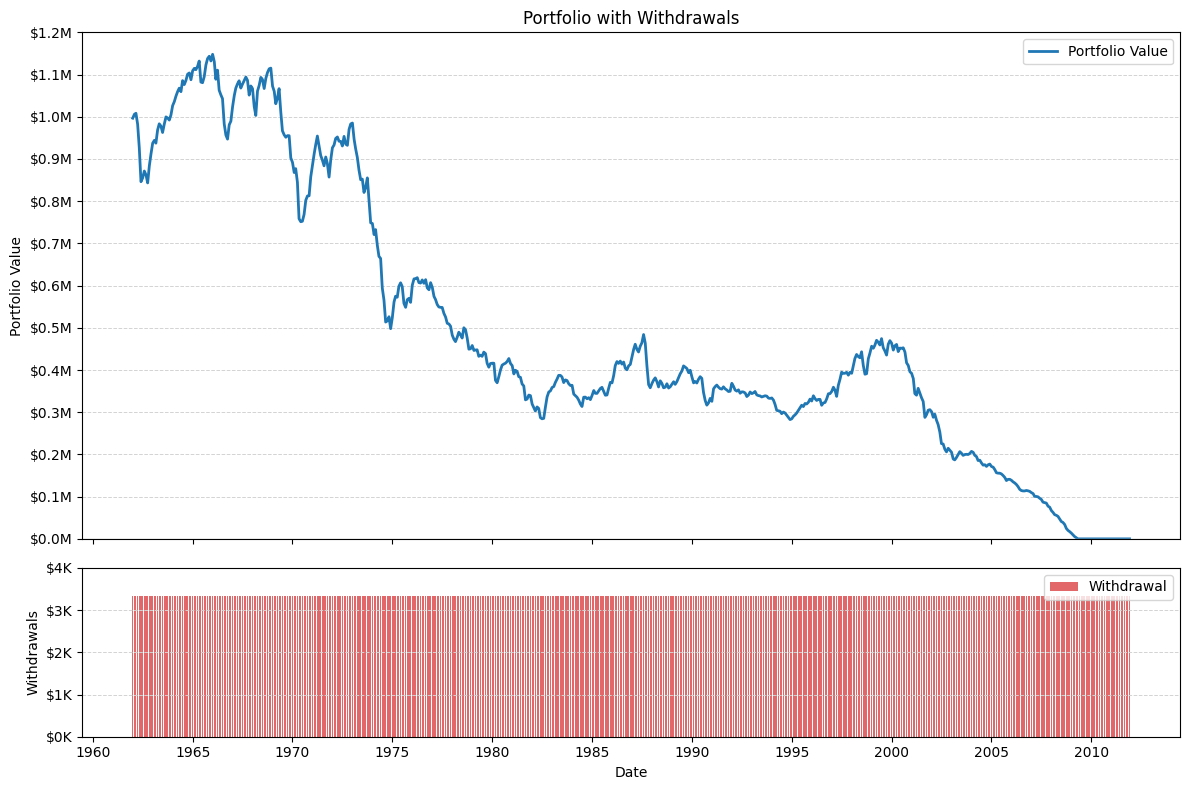

In [ ]:
plot_portfolio(four_pct_simulation)

### Now run multiple simulation paths at the 4% rule to see the distribution.

In [ ]:
def run_constant_withdrawals(df, annual_withdrawal_rate, num_months, stock_pct=0.75,
                             analysis_start_date='1871-01-01', initial_value=1_000_000,
                             verbose=False, return_full_paths=False):
    """
    Calculate all simulation paths for given parameters and return path details.

    Parameters
    ----------
    df : pd.DataFrame
        Market data
    annual_withdrawal_rate : float
        Annual withdrawal rate
    num_months : int
        Number of months in each simulation
    stock_pct : float
        Stock allocation percentage
    analysis_start_date : str
        Start date for analysis
    initial_value : float
        Initial portfolio value
    verbose : bool
        Print progress
    return_full_paths : bool
        If True, also return a DataFrame with all simulation details

    Returns
    -------
    list of tuples or tuple
        If return_full_paths=False: list of (start_date, end_date, final_value) tuples
        If return_full_paths=True: (path_results, full_paths_df) where full_paths_df
            contains all intermediate values with a run_idx column
    """
    # Convert analysis_start_date to datetime
    analysis_start = pd.to_datetime(analysis_start_date)

    # Filter dataframe to only include dates from analysis_start_date onwards
    df_filtered = df[df['Date'] >= analysis_start].copy()

    # Get all possible starting dates for simulation periods
    max_end_idx = len(df_filtered) - num_months
    if max_end_idx <= 0:
        if return_full_paths:
            return [], pd.DataFrame()
        return []  # Not enough data

    num_paths = max_end_idx + 1

    start_time = datetime.now()
    if verbose:
        print(f"{start_time.strftime('%H:%M:%S')} Starting simulation for WR = {annual_withdrawal_rate:.4f}, "
              f"num_months = {num_months}, starting = {analysis_start_date}, stock_pct = {stock_pct:.2f}, "
              f"num_paths = {num_paths}...")

    path_results = []
    full_paths_list = [] if return_full_paths else None

    for run_idx in range(num_paths):
        # Define the period for this simulation
        start_date = df_filtered.iloc[run_idx]['Date']
        end_idx = run_idx + num_months - 1
        end_date = df_filtered.iloc[end_idx]['Date']

        # Get withdrawals for this period
        withdrawals = get_constant_withdrawals(
            df_filtered,
            start_date,
            end_date,
            initial_value=initial_value,
            annual_percent_level=annual_withdrawal_rate
        )

        # Run vectorized simulation for this period
        simulation_result = run_retirement_simulation(
            df_filtered.iloc[run_idx:end_idx+1],
            withdrawals,
            initial_value=initial_value,
            stock_pct=stock_pct
        )

        # Get the final value (could be 0 if bankrupt)
        final_value = simulation_result['Period End Value'].iloc[-1]

        # Store the path result
        # We store final_value as-is (0 if failed, positive if succeeded)
        path_results.append((start_date, end_date, final_value))

        # Store full path if requested
        if return_full_paths:
            sim_df = simulation_result.copy()
            sim_df['run_idx'] = run_idx
            sim_df['start_date'] = start_date
            sim_df['end_date'] = end_date
            full_paths_list.append(sim_df)

    if verbose:
        total_seconds = (datetime.now() - start_time).total_seconds()
        print(f"...Done simulating {num_paths} retirement paths, took {total_seconds:.1f} seconds")

    if return_full_paths:
        # Combine all simulation results into one DataFrame
        full_paths_df = pd.concat(full_paths_list, ignore_index=True)
        return path_results, full_paths_df

    return path_results

In [ ]:
    _, four_percent_paths = run_constant_withdrawals(df,
                                                     annual_withdrawal_rate=0.04,
                                                     num_months=360,
                                                     stock_pct=0.75,
                                                     analysis_start_date='1925-01-01',
                                                     initial_value=1_000_000,
                                                     verbose=True,
                                                     return_full_paths=True)

    four_percent_paths.head()

15:45:45 Starting simulation for WR = 0.0400, num_months = 360, starting = 1925-01-01, stock_pct = 0.75, num_paths = 849...
...Done simulating 849 retirement paths, took 6.8 seconds


,Date,Period End Value,Withdrawal,run_idx,start_date,end_date
0,1925-01-01,9.966667e+05,3333.333333,0,1925-01-01,1954-12-01
1,1925-02-01,1.009945e+06,3333.333333,0,1925-01-01,1954-12-01
2,1925-03-01,9.853937e+05,3333.333333,0,1925-01-01,1954-12-01
3,1925-04-01,9.844310e+05,3333.333333,0,1925-01-01,1954-12-01
4,1925-05-01,1.003278e+06,3333.333333,0,1925-01-01,1954-12-01


In [ ]:
def plot_portfolio_paths(df, alpha=0.1, highlight_runs=None, figsize=(12, 8)):
    """
    Plot multiple portfolio simulation paths.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns: Date, Period End Value, Withdrawal, run_idx
        Contains multiple simulation runs identified by run_idx
    alpha : float
        Transparency for individual paths (lower = more transparent)
    highlight_runs : list or None
        List of run_idx values to highlight in bold
    figsize : tuple
        Figure size (width, height)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsize, sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Get unique runs
    runs = df['run_idx'].unique()
    num_runs = len(runs)

    # Color setup - use a colormap for variety if many paths
    if num_runs <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, num_runs))
        add_colorbar = False  # Don't need colorbar for discrete colors
        cmap = None
    else:
        # For many paths, use color gradient based on percentile of final value
        final_values = df.groupby('run_idx')['Period End Value'].last().values

        # Convert to percentiles to avoid outlier issues
        from scipy import stats
        percentiles = stats.rankdata(final_values, method='average') / len(final_values)

        # Use turbo colormap - rainbow colors with consistent darkness/visibility
        # Other good options: 'rainbow', 'jet', 'gist_rainbow', 'nipy_spectral'
        cmap = plt.cm.turbo
        colors = cmap(percentiles)
        add_colorbar = True

    # Determine the number of months for x-axis
    months_per_run = df.groupby('run_idx').size().iloc[0]
    x_months = np.arange(months_per_run)

    # --- Plot 1: Portfolio values ---
    for i, run_idx in enumerate(runs):
        run_data = df[df['run_idx'] == run_idx].copy()

        # Reset index to use month numbers instead of dates
        run_data = run_data.reset_index(drop=True)

        # Determine line properties
        if highlight_runs and run_idx in highlight_runs:
            linewidth = 2
            line_alpha = 1.0
            zorder = 10
        else:
            linewidth = 0.5
            line_alpha = alpha
            zorder = 1

        # Plot portfolio value path using month index
        ax1.plot(x_months, run_data["Period End Value"],
                linewidth=linewidth, alpha=line_alpha,
                color=colors[i],
                zorder=zorder)

    # Adaptive y-axis ticks for portfolio values
    y_min, y_max = df["Period End Value"].min(), df["Period End Value"].max()
    y_range = y_max - y_min
    candidates = [100_000, 500_000, 1_000_000, 5_000_000]
    step = min(candidates, key=lambda c: abs((y_range / c) - 10))

    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax1.axhline(0, color="black", linewidth=1, alpha=0.3)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title(f"Portfolio Simulation Paths (n={num_runs})")

    # Add success rate annotation
    success_rate = (df.groupby('run_idx')['Period End Value'].last() > 0).mean()
    ax1.text(0.02, 0.98, f'Success Rate: {success_rate:.1%}',
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # --- Plot 2: Withdrawals (lines instead of bars) ---
    for i, run_idx in enumerate(runs):
        run_data = df[df['run_idx'] == run_idx].copy()

        # Reset index to use month numbers
        run_data = run_data.reset_index(drop=True)

        # Determine line properties
        if highlight_runs and run_idx in highlight_runs:
            linewidth = 2
            line_alpha = 1.0
            zorder = 10
        else:
            linewidth = 0.5
            line_alpha = alpha
            zorder = 1

        # Plot withdrawal path as line using month index
        ax2.plot(x_months, run_data["Withdrawal"],
                linewidth=linewidth, alpha=line_alpha,
                color='tab:red', zorder=zorder)

    # Y-axis for withdrawals
    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    w_step = 1000  # fixed 1K spacing
    w_min_final = min(0, np.floor(w_min / w_step) * w_step)
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax2.set_ylabel("Withdrawals")

    # X-axis shows months
    ax2.set_xlabel("Months into Retirement")
    ax2.set_xlim(0, months_per_run - 1)

    # Set x-axis ticks to show years
    year_ticks = np.arange(0, months_per_run, 60)  # Every 5 years
    ax2.set_xticks(year_ticks)
    ax2.set_xticklabels([f"Year {int(m/12)}" for m in year_ticks])

    # Adjust layout before adding colorbar
    plt.subplots_adjust(right=0.88)

    # Add colorbar if using percentile coloring
    if add_colorbar:
        import matplotlib.cm as cm
        from matplotlib.colors import Normalize

        # Create a ScalarMappable for the colorbar
        norm = Normalize(vmin=0, vmax=100)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Add colorbar in its own axes to the right
        cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = plt.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Final Value Percentile', rotation=270, labelpad=20)

        # Set colorbar ticks to show key percentiles
        cbar.set_ticks([0, 10, 25, 50, 75, 90, 100])
        cbar.set_ticklabels(['0%\n(Worst)', '10%', '25%', '50%\n(Median)', '75%', '90%', '100%\n(Best)'])

    plt.show()

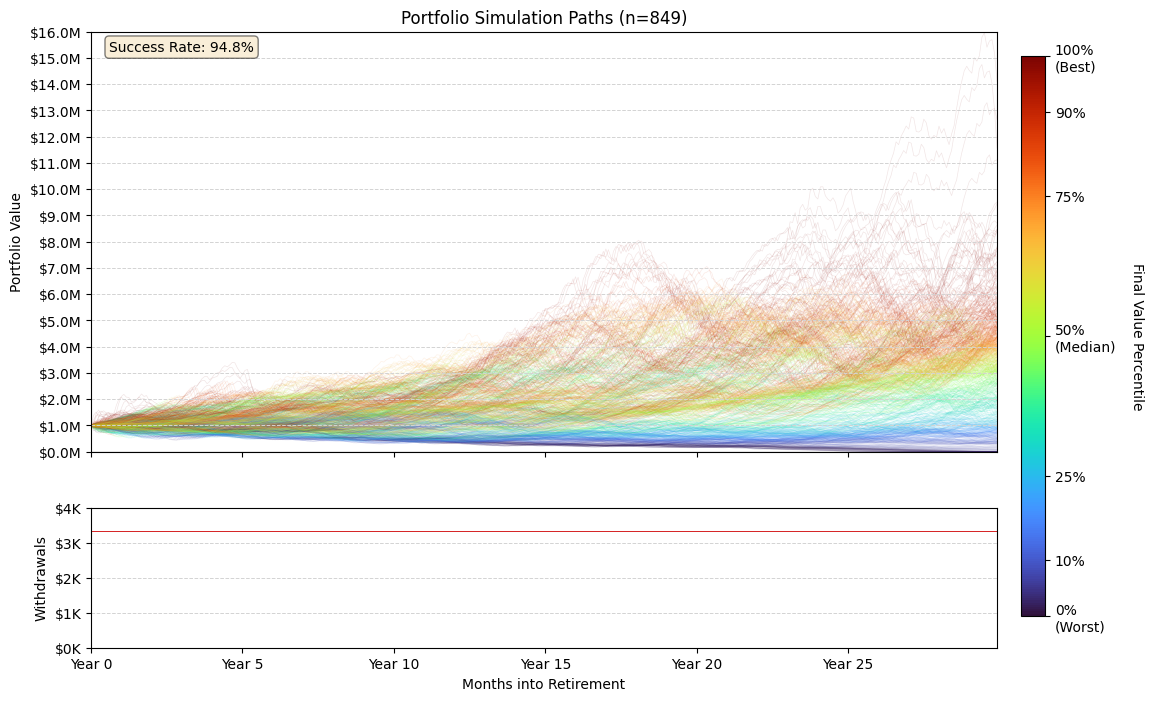

In [ ]:
plot_portfolio_paths(four_percent_paths)

# Goal Seek - Working Backwards

Great, we've now mastered FIRE 101. We pick a withdrawal rate (4%) and get a success rate (94.8% for all 30 year retirement paths since 1925).

Now it's time to start putting together the building blocks of the guardrails strategy. To do that, the fundamental thing we need to do is to work backwards from the above - given a desired success rate, to work out the withdrawal rate that results in it.

The simplest way to do that is to do a goal-seek or guess-and-check operation, trying different withdrawal rates until we find one that results in the desired success rate (or within some threshold of it).

Let's see how that plays out:

In [ ]:
@nb.jit(nopython=True)
def test_all_periods(portfolio_returns, num_months, initial_value, monthly_withdrawal):
    """
    Run the retirement simulation for one path, to capture success or failure of the path.
    This doesn't return the path itself so is only suitable for testing, not plotting.

    We're running this in a tight loop so we'll Numba-compile it for ultra-fast simulation.
    """
    num_periods = len(portfolio_returns) - num_months + 1
    successes = 0

    for start_idx in range(num_periods):
        value = initial_value

        for i in range(num_months):
            value = value * portfolio_returns[start_idx + i] - monthly_withdrawal
            if value <= 0:
                break

        if value > 0:
            successes += 1

    return successes / num_periods

def calculate_success_rate(df, withdrawal_rate, num_months, stock_pct=0.75,
                           analysis_start_date='1871-01-01', initial_value=1_000_000):
    """
    Calculate the success rate for a given withdrawal rate.
    Numba-accelerated version. Should be 500x+ faster than brute force.
    First call will be slower due to compilation, subsequent calls will be blazing fast.
    That way we can use it iteratively in a guess-and-check loop.
    """
    # Prepare data
    analysis_start = pd.to_datetime(analysis_start_date)
    df_filtered = df[df['Date'] >= analysis_start]

    # Calculate portfolio returns
    stock_prices = df_filtered['Real Total Return Price'].values
    bond_prices = df_filtered['Real Total Bond Returns'].values

    stock_returns = np.ones(len(stock_prices))
    stock_returns[1:] = stock_prices[1:] / stock_prices[:-1]

    bond_returns = np.ones(len(bond_prices))
    bond_returns[1:] = bond_prices[1:] / bond_prices[:-1]

    portfolio_returns = stock_pct * stock_returns + (1 - stock_pct) * bond_returns
    monthly_withdrawal = initial_value * withdrawal_rate / 12

    # Call the compiled function
    return test_all_periods(portfolio_returns, num_months, initial_value, monthly_withdrawal)

In [ ]:
def get_wr_for_fixed_success_rate(df, desired_success_rate, num_months,
                                  analysis_start_date='1871-01-01',
                                  initial_value=1_000_000, stock_pct=0.75,
                                  tolerance=0.001, max_iterations=50,
                                  verbose=False):
    """
    Compute the annual withdrawal rate such that a historical simulation over periods of the desired length
    yields the desired success rate.

    Parameters
    ----------
    df : pd.DataFrame
        The main dataframe with market data
    desired_success_rate : float
        The target chance of underspending (e.g., 0.90 for 90%),
        the percent of simulation paths that should have ending portfolio values > 0.
    num_months : int
        The size of the time window of the historical simulation paths to run
        (corresponds to the remaining time in retirement).
    analysis_start_date : str, optional
        The start date from which we should begin running simulation paths,
        if we do not want to start at the very beginning.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000)
    stock_pct : float, optional
        Percentage of portfolio in stocks (default 0.75)
    tolerance : float, optional
        Tolerance for success rate matching (default 0.001 = 0.1%)
    max_iterations : int, optional
        Maximum iterations for binary search (default 50)
    verbose : bool, optional
        Print progress (default False)

    Returns
    -------
    dict
        Dictionary containing:
        - 'withdrawal_rate': The annual withdrawal rate that achieves the target success rate
        - 'actual_success_rate': The actual success rate achieved
        - 'num_simulations': Number of simulation paths run
        - 'iterations': Number of binary search iterations performed
    """

    # Convert analysis_start_date to datetime
    analysis_start = pd.to_datetime(analysis_start_date)

    # Filter dataframe to only include dates from analysis_start_date onwards
    df_filtered = df[df['Date'] >= analysis_start].copy()

    # Get all possible starting dates for simulation periods
    max_end_idx = len(df_filtered) - num_months
    if max_end_idx <= 0:
        raise ValueError(f"Not enough data for {num_months} month simulations starting from {analysis_start_date}")

    num_paths = max_end_idx + 1

    # Binary search for the withdrawal rate
    low_rate = 0  # 0.0% annual withdrawal rate
    high_rate = 0.20  # 20% annual withdrawal rate

    iteration = 0
    best_rate = None
    best_success_rate = None

    if verbose:
        print(f"Searching for withdrawal rate with {desired_success_rate:.1%} success rate...")

    while iteration < max_iterations:
        mid_rate = (low_rate + high_rate) / 2

        current_success_rate = calculate_success_rate(df, mid_rate, num_months, stock_pct,
                                                      analysis_start_date, initial_value)

        # Check if we're within tolerance
        if abs(current_success_rate - desired_success_rate) <= tolerance:
            best_rate = mid_rate
            best_success_rate = current_success_rate
            if verbose:
                print(f"Converged! Found withdrawal rate within tolerance.")
            break

        # Adjust search bounds
        # If success rate is too high, we can withdraw more
        if current_success_rate > desired_success_rate:
            low_rate = mid_rate
            if verbose:
                print(f"Success rate at {mid_rate} is too high ({current_success_rate:.3f} > {desired_success_rate:.3f}), "
                      f"increasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]")
        else:
            # If success rate is too low, we need to withdraw less
            high_rate = mid_rate
            if verbose:
                print(f"Success rate at {mid_rate} is too low ({current_success_rate:.3f} < {desired_success_rate:.3f}), "
                      f"decreasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]")

        best_rate = mid_rate
        best_success_rate = current_success_rate
        iteration += 1

    if iteration >= max_iterations:
        if verbose:
            print(f"Reached maximum iterations ({max_iterations}). Returning best found rate.")

    # Return results
    return {
        'withdrawal_rate': best_rate,
        'actual_success_rate': best_success_rate,
        'num_simulations': num_paths,
        'iterations': iteration + 1
    }

In [ ]:

# Example: Find withdrawal rate for 90% success rate over 30-year periods
result = get_wr_for_fixed_success_rate(
    df=df,
    desired_success_rate=0.90,
    num_months=360,  # 30 years
    analysis_start_date='1871-01-01',
    initial_value=1_000_000,
    stock_pct=0.75,
    verbose=True
)
print(f"Annual withdrawal rate for desired success rate: {result['withdrawal_rate']:.4f} ({result['withdrawal_rate']*100:.2f}%)")
print(f"Actual success rate achieved: {result['actual_success_rate']:.4f} ({result['actual_success_rate']*100:.2f}%)")
print(f"Number of simulation paths: {result['num_simulations']}")
print(f"Binary search iterations: {result['iterations']}")

Searching for withdrawal rate with 90.0% success rate...
Success rate at 0.1 is too low (0.072 < 0.900), decreasing withdrawal rate range to [0.0000, 0.1000]
Success rate at 0.05 is too low (0.814 < 0.900), decreasing withdrawal rate range to [0.0000, 0.0500]
Success rate at 0.025 is too high (1.000 > 0.900), increasing withdrawal rate range to [0.0250, 0.0500]
Success rate at 0.037500000000000006 is too high (1.000 > 0.900), increasing withdrawal rate range to [0.0375, 0.0500]
Success rate at 0.043750000000000004 is too high (0.947 > 0.900), increasing withdrawal rate range to [0.0438, 0.0500]
Success rate at 0.046875 is too low (0.879 < 0.900), decreasing withdrawal rate range to [0.0438, 0.0469]
Success rate at 0.045312500000000006 is too high (0.912 > 0.900), increasing withdrawal rate range to [0.0453, 0.0469]
Success rate at 0.04609375 is too low (0.895 < 0.900), decreasing withdrawal rate range to [0.0453, 0.0461]
Success rate at 0.045703125000000004 is too high (0.902 > 0.900),

# The Guardrail Strategy

Now that we've established a working approach to back out a withdrawal rate from a target success rate, we can use it to implement the guardrails-based strategy described here: https://youtu.be/-_UtH2WCt2E

This approach is meant to allow retirees to spend more by adapting to market conditions, allowing larger withdrawals when the market is up, and reducing them when the market is down. Instead of recalculating every month or even every year, the aim is to minimize clients' need to re-budget frequently by keeping spending constant until a fixed "guardrail" is reached that will then cause the budget to increase or decrease.

### Methodology Notes

For maximum confidence, any set of optimal inputs (aka "hyper parameters") we choose for this guardrail strategy - or any other withdrawal strategy we test - should be subject to out-of-sample validation. That means we should choose a set of inputs that work on say 1871-1980 and then validate that they are stil good when applied to 1981-2025 (at a bare minimum - for better results we would hold out multiple slices).

If we don't do this, we are essentially "overfitting" to the historical data - in other words we are discovering and capitalizing on quirks in the data that won't be repeated in the future.

What we want to do is capture general properties, not one-off quirks. We're not retiring in 1962 - we're retiring now, and the future is unknown! With Monte Carlo this type of cross-validation is easy, but with historical simulations - there's unfortunately only so much data.

In [ ]:
def get_guardrail_withdrawals(df, start_date, end_date,
                              analysis_start_date='1871-01-01',
                              initial_value=1_000_000,
                              stock_pct=0.75,
                              target_success_rate=0.90,
                              upper_guardrail_success=1.00,
                              lower_guardrail_success=0.75,
                              upper_adjustment_fraction=1.0,  # If we hit an upper guardrail, go straight to the new spending
                              lower_adjustment_fraction=0.1,  # If we hit a lower guardrail, adjust spending gradually
                              adjustment_threshold=0.05,      # Don't tell the client to adjust spending unless new number differs by more than 5% from previous
                              verbose=False):
    """
    Creates a dataframe of withdrawals that follow an adaptive guardrail strategy.

    The strategy:
    1. Each month, calculate the withdrawal rate that gives target_success_rate
    2. Calculate portfolio values that would make current spending have upper/lower success rates
    3. If portfolio hits guardrails, adjust spending
    4. Only implement adjustment if it exceeds threshold (to avoid constant small changes)

    Returns
    -------
    pd.DataFrame
        A dataframe with Date, Withdrawal, and diagnostic columns.
    """
    # Filter to analysis period
    mask = (df["Date"] >= pd.to_datetime(start_date)) & (df["Date"] <= pd.to_datetime(end_date))
    subset = df[mask].copy().reset_index(drop=True)

    # Pre-compute portfolio returns for the entire historical period (for speed)
    all_stock_prices = df['Real Total Return Price'].values
    all_bond_prices = df['Real Total Bond Returns'].values

    stock_returns = np.ones(len(all_stock_prices))
    stock_returns[1:] = all_stock_prices[1:] / all_stock_prices[:-1]

    bond_returns = np.ones(len(all_bond_prices))
    bond_returns[1:] = all_bond_prices[1:] / all_bond_prices[:-1]

    portfolio_returns = stock_pct * stock_returns + (1 - stock_pct) * bond_returns

    # Initialize results storage
    results = []

    # Get the initial withdrawal rate based on the target success rate
    #
    initial_wr = get_wr_for_fixed_success_rate(df=df,
                                               desired_success_rate=target_success_rate,
                                               num_months=len(subset),
                                               analysis_start_date=analysis_start_date,
                                               initial_value=initial_value,
                                               stock_pct=stock_pct,
                                               tolerance=0.001,
                                               max_iterations=50,
                                               verbose=False)['withdrawal_rate']

    # State variables
    current_portfolio_value = initial_value
    previous_monthly_spending = initial_value * initial_wr / 12
    previous_spending_date = pd.to_datetime(start_date)

    # Get CPI data for inflation adjustments
    cpi_data = df[['Date', 'Consumer Price Index CPI']].copy()

    for i, row in subset.iterrows():
        current_date = row['Date']
        months_remaining = len(subset) - i

        if verbose and i % 12 == 0:
            print(f"Processing {current_date.strftime('%Y-%m')}, portfolio=${current_portfolio_value:,.0f}, months_remaining={months_remaining}")

        # Calculate 3 withdrawal rates: the target, and the upper and lower guardrail, based on the current portfolio value and months remaining
        #
        target_wr = get_wr_for_fixed_success_rate(df=df,
                                                  desired_success_rate=target_success_rate,
                                                  num_months=months_remaining,
                                                  analysis_start_date=analysis_start_date,
                                                  initial_value=current_portfolio_value,
                                                  stock_pct=stock_pct,
                                                  tolerance=0.001,
                                                  max_iterations=50,
                                                  verbose=False)['withdrawal_rate']

        upper_wr = get_wr_for_fixed_success_rate(df=df,
                                                 desired_success_rate=upper_guardrail_success,
                                                 num_months=months_remaining,
                                                 analysis_start_date=analysis_start_date,
                                                 initial_value=current_portfolio_value,
                                                 stock_pct=stock_pct,
                                                 tolerance=0.001,
                                                 max_iterations=50,
                                                 verbose=False)['withdrawal_rate']

        lower_wr = get_wr_for_fixed_success_rate(df=df,
                                                 desired_success_rate=lower_guardrail_success,
                                                 num_months=months_remaining,
                                                 analysis_start_date=analysis_start_date,
                                                 initial_value=current_portfolio_value,
                                                 stock_pct=stock_pct,
                                                 tolerance=0.001,
                                                 max_iterations=50,
                                                 verbose=False)['withdrawal_rate']

        # The new target spending is the target withdrawal rate times the current portfolio value.
        #
        target_monthly_spending = current_portfolio_value * target_wr / 12

        # The guardrail portfolio values are the values that would result in the current target withdrawal amount
        # representing a probability of success equal to each guardrail's probability.
        #
        upper_guardrail_value = target_monthly_spending / upper_wr * 12
        lower_guardrail_value = target_monthly_spending / lower_wr * 12

        # Step 3: Check if we hit guardrails
        hit_upper = current_portfolio_value >= upper_guardrail_value
        hit_lower = current_portfolio_value <= lower_guardrail_value

        # Step 4: Calculate proposed spending adjustment
        if hit_upper:
            # Adjust spending upward (target - previous will be positive)
            new_proposed_spending = previous_monthly_spending + upper_adjustment_fraction * (target_monthly_spending - previous_monthly_spending)
            guardrail_hit = "UPPER"
        elif hit_lower:
            # Adjust spending downward (target - previous will be negative)
            new_proposed_spending = previous_monthly_spending + lower_adjustment_fraction * (target_monthly_spending - previous_monthly_spending)
            guardrail_hit = "LOWER"
        else:
            new_proposed_spending = previous_monthly_spending
            guardrail_hit = "NONE"

        # Step 5: Apply inflation adjustment to compare with previous spending
        # Note that the inflation-adjusted number is used only for this threshold check then thrown away. We want to
        # gate the client advice on whether their nominal spending amount will change by more than 5%, but this will not
        # be the nominal amount we tell the client (since it's adjusted from the last adjustment date, not from 1871).
        # The entire calculation, aside from this one threshold check, is done in real dollars.
        #
        from_cpi = cpi_data[cpi_data['Date'] >= previous_spending_date]['Consumer Price Index CPI'].iloc[0]
        to_cpi = cpi_data[cpi_data['Date'] >= current_date]['Consumer Price Index CPI'].iloc[0]

        new_proposed_spending_adjusted = new_proposed_spending * to_cpi / from_cpi

        # Step 6: Only adjust if this new inflation-adjusted dollar amount - due to guardrail hit, pure inflation, or both -
        # differs from the previous real dollar amount by more than the configured threshold.
        #
        percent_change = abs(new_proposed_spending_adjusted - previous_monthly_spending) / previous_monthly_spending

        if percent_change > adjustment_threshold:
            # Make the adjustment
            actual_monthly_spending = new_proposed_spending
            previous_spending_date = current_date  # Reset inflation baseline
            adjustment_made = True
        else:
            # Keep previous spending (inflation adjusted)
            actual_monthly_spending = previous_monthly_spending
            adjustment_made = False

        # Store results
        results.append({
            'Date': current_date,
            'Withdrawal': actual_monthly_spending,
            'Portfolio_Value': current_portfolio_value,
            'Target_WR': target_wr,
            'Target_Spending': target_monthly_spending,
            'Upper_Guardrail': upper_guardrail_value,
            'Lower_Guardrail': lower_guardrail_value,
            'Guardrail_Hit': guardrail_hit,
            'Percent_Change': percent_change,
            'Adjustment_Made': adjustment_made
        })

        # Update portfolio value for next month
        # Apply withdrawal
        current_portfolio_value -= actual_monthly_spending

        # Apply market returns (if not at end)
        if i < len(subset) - 1:
            # Find the index in the full dataset
            full_idx = df[df['Date'] == current_date].index[0]
            month_return = portfolio_returns[full_idx + 1] if full_idx + 1 < len(portfolio_returns) else 1.0
            current_portfolio_value *= month_return

        # Update state
        previous_monthly_spending = actual_monthly_spending

        # Check for bankruptcy
        if current_portfolio_value <= 0:
            if verbose:
                print(f"Portfolio depleted at {current_date}")
            break

    return pd.DataFrame(results)

In [32]:
results = get_guardrail_withdrawals(
    df,
    start_date='1968-04-01',
    end_date='2018-03-31',
    initial_value=1_000_000,
    stock_pct=0.75,
    adjustment_threshold=0.05,
    target_success_rate=0.80,
    upper_guardrail_success=1.00,
    lower_guardrail_success=0.25,
    upper_adjustment_fraction=1.0,
    lower_adjustment_fraction=0.1,
    verbose=True
)

# Analyze results
print(f"\nStarting withdrawal: ${results['Withdrawal'].iloc[0]:,.0f}/month")
print(f"Ending withdrawal: ${results['Withdrawal'].iloc[-1]:,.0f}/month")
print(f"Number of adjustments: {results['Adjustment_Made'].sum()}")
print(f"Upper guardrail hits: {(results['Guardrail_Hit'] == 'UPPER').sum()}")
print(f"Lower guardrail hits: {(results['Guardrail_Hit'] == 'LOWER').sum()}")

Processing 1968-04, portfolio=$1,000,000, months_remaining=600
Processing 1969-04, portfolio=$974,938, months_remaining=588
Processing 1970-04, portfolio=$791,353, months_remaining=576
Processing 1971-04, portfolio=$886,775, months_remaining=564
Processing 1972-04, portfolio=$876,950, months_remaining=552
Processing 1973-04, portfolio=$825,981, months_remaining=540
Processing 1974-04, portfolio=$638,516, months_remaining=528
Processing 1975-04, portfolio=$523,804, months_remaining=516
Processing 1976-04, portfolio=$556,917, months_remaining=504
Processing 1977-04, portfolio=$495,372, months_remaining=492
Processing 1978-04, portfolio=$420,361, months_remaining=480
Processing 1979-04, portfolio=$384,732, months_remaining=468
Processing 1980-04, portfolio=$309,094, months_remaining=456
Processing 1981-04, portfolio=$312,075, months_remaining=444
Processing 1982-04, portfolio=$241,412, months_remaining=432
Processing 1983-04, portfolio=$276,013, months_remaining=420
Processing 1984-04, po

In [30]:
def plot_guardrail_portfolio(df, figsize=(14, 8)):
    """
    Plot portfolio value with guardrail bounds and withdrawals over time.

    Parameters
    ----------
    df : pd.DataFrame
        Results from get_guardrail_withdrawals with columns:
        Date, Withdrawal, Portfolio_Value, Upper_Guardrail, Lower_Guardrail, etc.
    figsize : tuple
        Figure size (width, height)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsize, sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Plot 1: Portfolio values with guardrails ---
    # Plot the guardrail bounds as shaded area
    ax1.fill_between(df["Date"],
                     df["Lower_Guardrail"],
                     df["Upper_Guardrail"],
                     alpha=0.2, color='gray',
                     label='Guardrail Zone')

    # Plot the guardrail lines
    ax1.plot(df["Date"], df["Upper_Guardrail"],
            linestyle='--', color='green', alpha=0.7, linewidth=1,
            label='Upper Guardrail (100% success)')
    ax1.plot(df["Date"], df["Lower_Guardrail"],
            linestyle='--', color='red', alpha=0.7, linewidth=1,
            label='Lower Guardrail (75% success)')

    # Plot actual portfolio value
    ax1.plot(df["Date"], df["Portfolio_Value"],
            label="Portfolio Value", linewidth=2.5, color='blue')

    # Mark points where adjustments were made
    adjustment_points = df[df['Adjustment_Made'] == True]
    if not adjustment_points.empty:
        ax1.scatter(adjustment_points["Date"],
                   adjustment_points["Portfolio_Value"],
                   color='orange', s=50, zorder=5,
                   label=f'Spending Adjustments ({len(adjustment_points)})')

    # Mark guardrail hits with different markers
    upper_hits = df[df['Guardrail_Hit'] == 'UPPER']
    lower_hits = df[df['Guardrail_Hit'] == 'LOWER']

    if not upper_hits.empty:
        ax1.scatter(upper_hits["Date"], upper_hits["Portfolio_Value"],
                   marker='^', color='green', s=30, zorder=4, alpha=0.7,
                   label=f'Upper Guardrail Hits ({len(upper_hits)})')

    if not lower_hits.empty:
        ax1.scatter(lower_hits["Date"], lower_hits["Portfolio_Value"],
                   marker='v', color='red', s=30, zorder=4, alpha=0.7,
                   label=f'Lower Guardrail Hits ({len(lower_hits)})')

    # Adaptive y-axis ticks
    all_values = pd.concat([df["Portfolio_Value"],
                           df["Upper_Guardrail"],
                           df["Lower_Guardrail"]])
    y_min, y_max = all_values.min(), all_values.max()
    y_range = y_max - y_min

    # Choose appropriate tick spacing
    if y_max > 5_000_000:
        step = 1_000_000
    elif y_max > 1_000_000:
        step = 500_000
    else:
        step = 100_000

    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7, alpha=0.5)
    ax1.axhline(0, color="black", linewidth=1, alpha=0.3)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Guardrail Strategy: Portfolio Value and Spending Adjustments")
    ax1.legend(loc='upper right', fontsize=9)

    # Add text box with summary statistics
    final_value = df['Portfolio_Value'].iloc[-1]
    initial_value = df['Portfolio_Value'].iloc[0]
    total_return = (final_value / initial_value - 1) * 100
    avg_withdrawal = df['Withdrawal'].mean()

    stats_text = (f'Final Value: ${final_value:,.0f}\n'
                 f'Total Return: {total_return:.1f}%\n'
                 f'Avg Withdrawal: ${avg_withdrawal:,.0f}/mo')

    ax1.text(0.02, 0.98, stats_text,
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

    # --- Plot 2: Withdrawals over time ---
    # Color-code withdrawals based on adjustments
    colors = ['orange' if adj else 'darkblue'
              for adj in df['Adjustment_Made']]

    # Plot as line with markers at adjustment points
    ax2.plot(df["Date"], df["Withdrawal"],
            color='darkblue', alpha=0.7, linewidth=1.5,
            label='Monthly Withdrawal')

    # Highlight adjustment points
    if not adjustment_points.empty:
        ax2.scatter(adjustment_points["Date"],
                   adjustment_points["Withdrawal"],
                   color='orange', s=30, zorder=5,
                   label='Adjusted')

    # Add target spending as reference
    if 'Target_Spending' in df.columns:
        ax2.plot(df["Date"], df["Target_Spending"],
                linestyle=':', color='gray', alpha=0.5, linewidth=1,
                label='Target (90% success)')

    # Y-axis for withdrawals
    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    if 'Target_Spending' in df.columns:
        w_max = max(w_max, df["Target_Spending"].max())
        w_min = min(w_min, df["Target_Spending"].min())

    w_step = 1000  # Fixed 1K spacing
    w_min_final = np.floor(w_min / w_step) * w_step
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7, alpha=0.5)
    ax2.set_ylabel("Monthly Withdrawal")
    ax2.legend(loc='upper right', fontsize=9)

    # Add withdrawal statistics
    initial_withdrawal = df['Withdrawal'].iloc[0]
    final_withdrawal = df['Withdrawal'].iloc[-1]
    withdrawal_change = (final_withdrawal / initial_withdrawal - 1) * 100

    withdrawal_stats = (f'Initial: ${initial_withdrawal:,.0f}/mo\n'
                       f'Final: ${final_withdrawal:,.0f}/mo\n'
                       f'Change: {withdrawal_change:+.1f}%')

    ax2.text(0.02, 0.98, withdrawal_stats,
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
            fontsize=9)

    # Shared x-axis
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))   # Every 5 years
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Rotate x-axis labels if needed
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, ha='center')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*60)
    print("GUARDRAIL STRATEGY SUMMARY")
    print("="*60)
    print(f"Period: {df['Date'].iloc[0].strftime('%Y-%m')} to {df['Date'].iloc[-1].strftime('%Y-%m')}")
    print(f"Initial Portfolio: ${df['Portfolio_Value'].iloc[0]:,.0f}")
    print(f"Final Portfolio: ${final_value:,.0f}")
    print(f"Total Withdrawals: ${df['Withdrawal'].sum():,.0f}")
    print(f"Number of Spending Adjustments: {df['Adjustment_Made'].sum()}")
    print(f"Upper Guardrail Hits: {(df['Guardrail_Hit'] == 'UPPER').sum()}")
    print(f"Lower Guardrail Hits: {(df['Guardrail_Hit'] == 'LOWER').sum()}")
    print(f"Average Monthly Withdrawal: ${avg_withdrawal:,.0f}")
    print(f"Withdrawal Range: ${df['Withdrawal'].min():,.0f} - ${df['Withdrawal'].max():,.0f}")

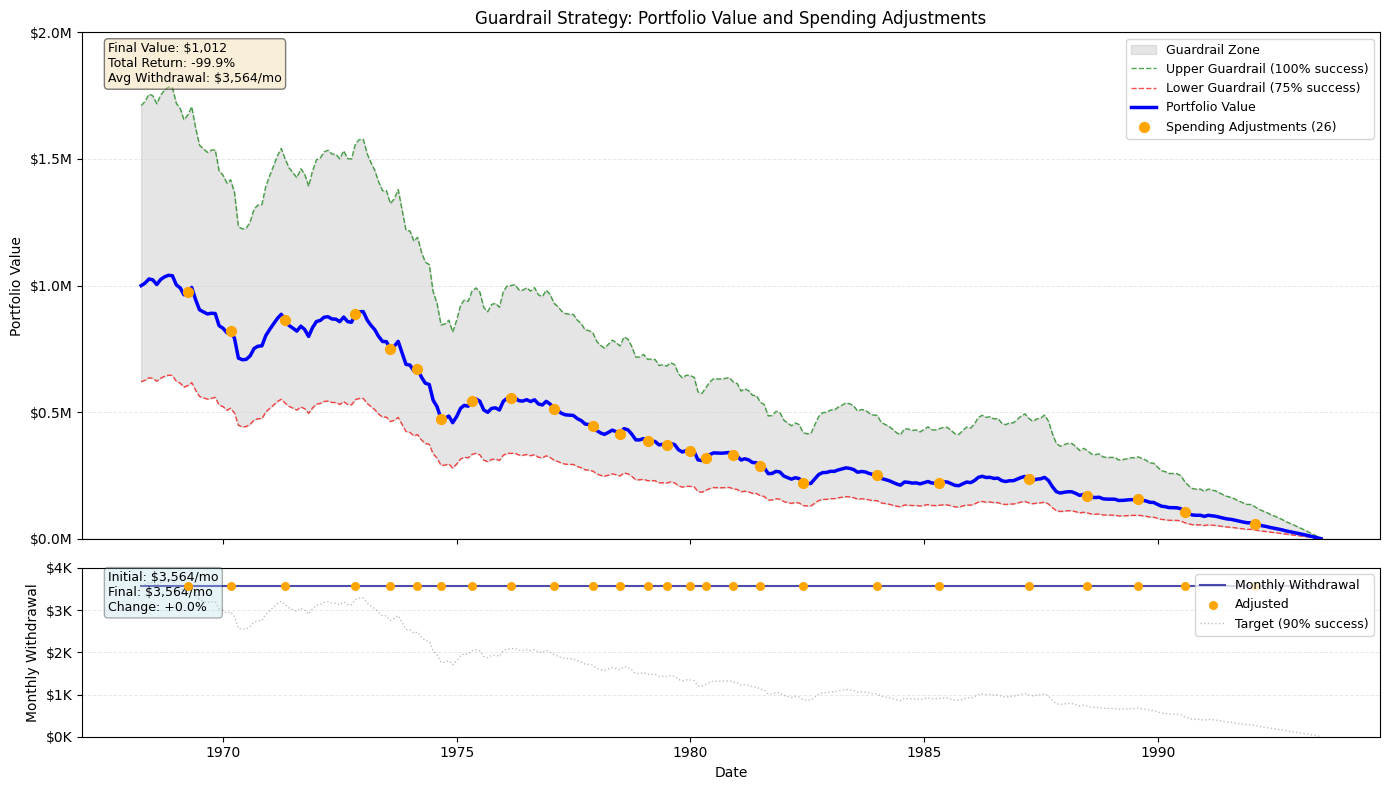


GUARDRAIL STRATEGY SUMMARY
Period: 1968-04 to 1993-07
Initial Portfolio: $1,000,000
Final Portfolio: $1,012
Total Withdrawals: $1,083,594
Number of Spending Adjustments: 26
Upper Guardrail Hits: 0
Lower Guardrail Hits: 0
Average Monthly Withdrawal: $3,564
Withdrawal Range: $3,564 - $3,564


In [33]:
plot_guardrail_portfolio(results)